In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [38]:
from NuPy import oscprobs

a = 0
theta13 = np.pi/20
theta12 = np.pi/6
theta23 = np.pi/4
deltacp = np.pi/6
alpha = 0.03
delta = lambda L, En: (1.27 * (2e-3) * L)/En

baseline = 10
energy = 0.1

prob = oscprobs.OscProbIdentities(alpha, a, delta(baseline, energy), deltacp, theta12, theta13, theta23)
probmatrix = prob.probabilities()

print(probmatrix)


[[0.99401645 0.00347523 0.00250832]
 [0.00335179 0.93916117 0.05748704]
 [0.00263175 0.0573636  0.94000464]]


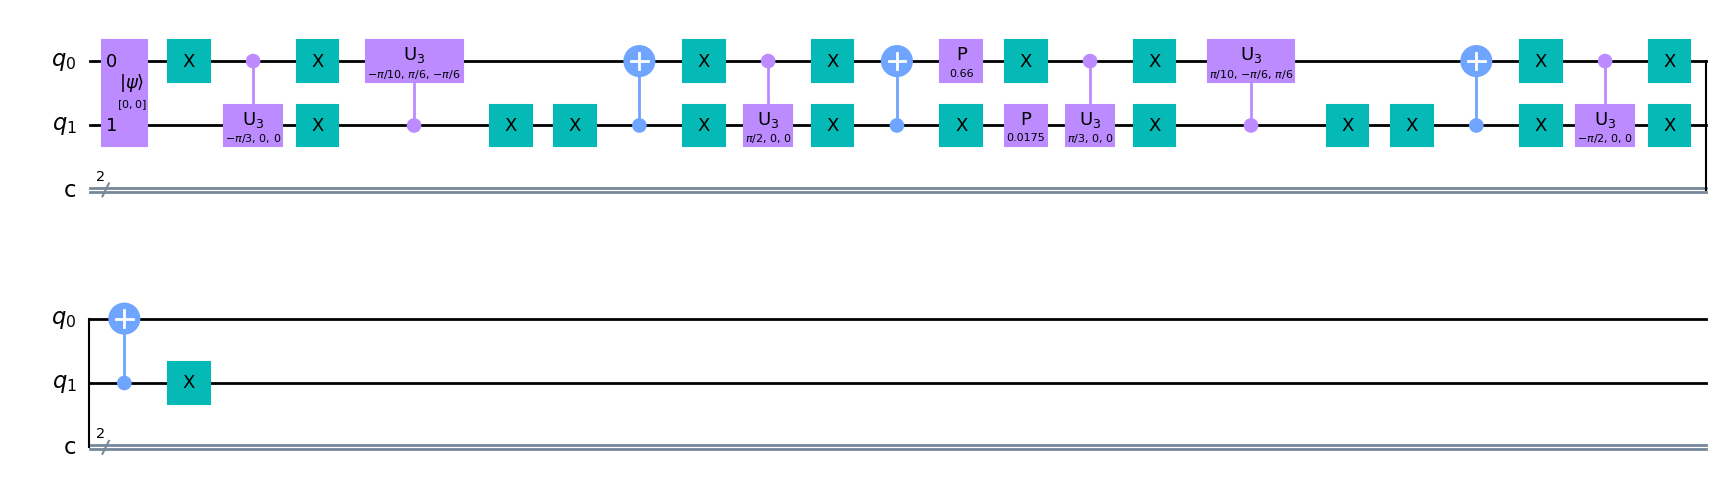

0.853515625


In [37]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.extensions import CU3Gate
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Define the parameters for neutrino oscillations
theta12 = np.pi/6
theta13 = np.pi/20
theta23 = np.pi/4
deltacp = np.pi/6

delmsq13 = -2.6e-3
delmsq12 = -6.9e-5

L = 10 # 100 * 1e+3  # Distance traveled by the neutrino (in km)
E = 0.1 # 0.001 * 1e+9  # Energy of the neutrino (in GeV)

def PMNS(qc, dagger = False):
    global theta12, theta13, theta23, deltacp
    
    flip = (-1)**(int(dagger))
    
    theta12 = flip * theta12
    theta13 = flip * theta13
    theta23 = flip * theta23
    deltacp = flip * deltacp
    
    qc.x(0)
    qc.append(CU3Gate(-2 * theta12, 0, 0), [0, 1]) # [control_qubit, target_qubit]
    qc.x(0)

    qc.x(1)
    qc.append(CU3Gate(-2 * theta13, deltacp, -deltacp), [1, 0])
    qc.x(1)

    qc.x(1)
    qc.cx(1, 0)
    qc.x(1)

    qc.x(0)
    qc.append(CU3Gate(2 * theta23, 0, 0), [0, 1])
    qc.x(0)

    qc.x(1)
    qc.cx(1, 0)
    qc.x(1)
    
def S(qc):
    phase1 = - 2 * ((1.27 * delmsq13 * L)/E)
    phase2 = - 2 * ((1.27 * delmsq12 * L)/E)
    
    qc.p(phase1, 0)
    qc.p(phase2, 1)

def osc_prob(E):
# Create a quantum circuit with 3 qubits
qc = QuantumCircuit(2, 2)


    


qc.initialize('00', qc.qubits)

PMNS(qc)
S(qc)
PMNS(qc, dagger=True)

display(qc.draw('mpl'))

qc.measure(range(2), range(2))

# # Define the simulator backend
backend = Aer.get_backend('qasm_simulator')

shots = 8192

# # Execute the circuit and get the results
job = execute(qc, backend, shots=shots)
counts = job.result().get_counts(qc)

prob = counts['00']/shots

print(prob)

Theoretical probabilities:
P(ν_e -> ν_e): 0.6265987458659933
P(ν_e -> ν_μ): 0.37340125413400677

Experimental probabilities:
P(ν_e -> ν_e): 0.70703125
P(ν_e -> ν_μ): 0.29296875


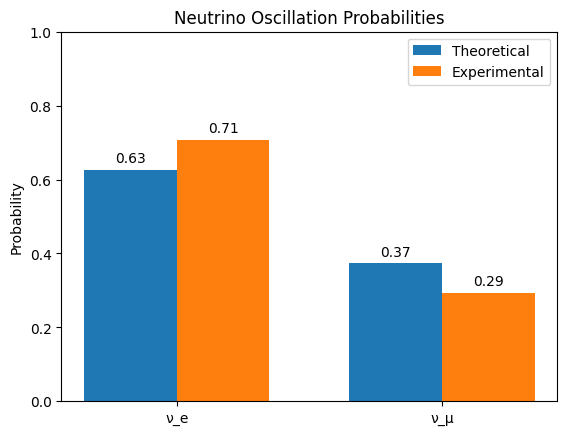

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute

# Define the initial state of the neutrino
initial_state = [1, 0]  # Pure |ν_e⟩ state

# Define the oscillation parameters
theta = 0.587  # Mixing angle (in radians)
delta = 1.571  # Phase difference (in radians)

# Define the time evolution factor
t = 1  # Time in arbitrary units

# Theoretical calculation of oscillation probabilities
P_ee = np.cos(theta)**2 + np.sin(theta)**2 * np.cos(2 * delta) * np.sin(theta)**2 * np.sin(t)**2
P_emu = np.sin(theta)**2 - np.sin(theta)**2 * np.cos(2 * delta) * np.sin(theta)**2 * np.sin(t)**2

# Create a quantum circuit with 1 qubit
qc = QuantumCircuit(1)

# Initialize the qubit with the initial state
qc.initialize(initial_state, 0)

# Perform the neutrino oscillation
qc.ry(2 * theta, 0)  # Apply the rotation around the y-axis
qc.rz(delta, 0)     # Apply the rotation around the z-axis

# Measure the qubit
qc.measure_all()

# Simulate the circuit
simulator = Aer.get_backend('aer_simulator')
job = execute(qc, simulator, shots=1024)
result = job.result()
counts = result.get_counts(qc)

# Calculate the probabilities from the measurement results
P_ee_exp = counts.get('0', 0) / 1024
P_emu_exp = counts.get('1', 0) / 1024

# Print the theoretical and experimental probabilities
print("Theoretical probabilities:")
print("P(ν_e -> ν_e):", P_ee)
print("P(ν_e -> ν_μ):", P_emu)
print("\nExperimental probabilities:")
print("P(ν_e -> ν_e):", P_ee_exp)
print("P(ν_e -> ν_μ):", P_emu_exp)

# Plot the probabilities
labels = ['ν_e', 'ν_μ']
theoretical_probs = [P_ee, P_emu]
experimental_probs = [P_ee_exp, P_emu_exp]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, theoretical_probs, width, label='Theoretical')
rects2 = ax.bar(x + width/2, experimental_probs, width, label='Experimental')

ax.set_ylabel('Probability')
ax.set_title('Neutrino Oscillation Probabilities')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1])
ax.legend()

# Attach a label to each bar displaying the probability
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


In [20]:
!pip install nupyosc


[notice] A new release of pip available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
